In [38]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from scipy.spatial import distance

%matplotlib inline
from IPython.display import HTML

plt.rcParams["figure.figsize"] = (6,4.5) # adjusts plot dimension parameters
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["font.sans-serif"] = ['Tahoma'] # changes font

In [39]:
def animate_trajectory(q_traj,skip=10,time_interval=50,colors=cm.rainbow(np.linspace(0, 1, 12))):
    '''
    Function for animating the trajectory of atoms.
    '''
    frames = []   
    Nframes = int(len(q_traj)/skip) 
    
    for n in range(Nframes): 
        qq = q_traj[n*skip,:] 
        frame = plt.scatter( qq[::2],qq[1::2],s=250,edgecolor='k', c = colors)    

        frames.append( (frame,) )
    im_ani = animation.ArtistAnimation(plt.gcf(),frames,interval=time_interval);
    plt.close()
    return im_ani

### Ben's Example Hamiltonian System:

<img src="ben_system.png" width = 300> 

**Lennard-Jones Potential:**

In [40]:
def phi_LJ(r, sigma=2**6, alpha_LJ=1):
    '''
    This function takes the distance between two atoms (r) as input and 
    returns their LJ potential: alpha_LJ*[(sigma/r)^12 - (sigma/r)^6 ] (scalar).
    '''
    phi = np.power((sigma/r),12) - np.power((sigma/r),6)
    return alpha_LJ*phi

In [41]:
def U_LJ(q):
    '''
    The function takes the 2N-dimensional trajectory vector and returns the LJ potential energy (scalar).
    '''
    N = int(len(q)/2) # number of atoms in R^2
    U = []
    # loops to create a vector where each element is Phi_LJ for each combination of 2 out of N atoms
    for i in range(N-1): 
        for j in range(i+1,N):
            qi=q[2*i:(2*i+2)]
            qj=q[2*j:(2*j+2)]
            U.append(phi_LJ(np.linalg.norm(qi-qj)))
    
    return np.sum(U)

In [42]:
def force_LJ(q1,q2): 
    '''
    This function computes LJ force between 2 atoms. It takes positions of 2 atoms (2-dimensional), 
    the output consists of the energy (scalar) and 2 2D vectors f = -grad(phi_LJ) (one force vector per atom)
    '''
    r = distance.euclidean(q1,q2)
    energy = phi_LJ(r)
    q1x = q1[0] 
    q1y = q1[1]
    q2x = q2[0] 
    q2y = q2[1]
    
    dUlj_dr = -12/r**13 + 6/r**7   
    dnorm_dq1x = (q1x-q2x)/r 
    dnorm_dq1y = (q1y-q2y)/r    
    dnorm_dq2x = -(q1x-q2x)/r   
    dnorm_dq2y = -(q1y-q2y)/r  
    # derivatives of U_LJ(q1,q2) w.r.t. q1x, q1y, q2x, q2y
    dulj_dq1x = dUlj_dr * dnorm_dq1x
    dulj_dq1y = dUlj_dr * dnorm_dq1y
    dulj_dq2x = dUlj_dr * dnorm_dq2x
    dulj_dq2y = dUlj_dr * dnorm_dq2y
    
    F1 = np.zeros_like(q1) 
    F2 = np.zeros_like(q2)
    
    # force = -gradient 
    F1[0] = -dulj_dq1x
    F1[1] = -dulj_dq1y
    F2[0] = -dulj_dq2x
    F2[1] = -dulj_dq2y    
    
    return energy, F1,F2

**Spring Potential:**

In [44]:
def phi_spring(r,r0=1,k=18/2**(42/3)):
    #k=18/2**(32/3)
    #k=1
    #k=18/2**(27/3)
    #k=18/2**(37/3)
    '''
    This function takes the norm of 1 atoms (r) as input and 
    returns its spring potential: 0.5*k*(r-r0)**2 (scalar).
    '''
    return 0.5*k*((r-r0)**2)

**Updated Spring Potential:**

In [45]:
def U_spring(q):
    '''
    The function takes the 2N-dimensional position vector and returns the spring potential energy (scalar).
    '''
    N = int(len(q)/2) # number of atoms in R^2
    s = 0
    q0 = np.zeros(N) #r0
    for i in range(N):
        qi = q[2*i:(2*i+2)]
        s += phi_spring(np.linalg.norm(qi), np.linalg.norm(q0))
        
    return s

**Force spring**

In [46]:
def force_spring(qi):
    '''
    Computes the spring force for 1 atom. Input is a 2D position of 1 atom, output consists of
    the potential energy (scalar) and the 2D force vector f = -grad(phi_spring).
    '''
    # input is one atom (2-dimensional), output is f = -grad(U_spring) (a 2D vector)
    r = np.linalg.norm(qi)
    r0 = 1  # change?
    #k = 18/2**(37/3)    # change?
    #k = 18/2**(27/3)
    #k=1
    #k = 18/2**(32/3)
    k = 18/2**(42/3)
    energy = phi_spring(r,r0)
    
    qix = qi[0] 
    qiy = qi[1]
    
    dUs_dr = k*(r-r0)  

    dus_dqix = dUs_dr * qix / r
    dus_dqiy = dUs_dr * qiy / r
    
    Fi = np.zeros_like(qi)
    
    # force = -gradient
    Fi[0] = -dus_dqix
    Fi[1] = -dus_dqiy
    
    return energy, Fi

In [47]:
def total_force(q): 
    '''
    Computes the total force and potential energy across all atoms. Input is a position vector of N atoms 
    (2N-dimensional), output consists of the total potential energy (scalar) pe = pe_LJ + pe_spring  
    and 2N dimensional force vector f = force_LJ + force_spring.
    '''    
    N = int(len(q)/2) # number of atoms in R^2
    pe_s = 0  # spring potential energy
    pe_LJ = 0 # LJ potential energy
    f = np.zeros(2*N) # vector of forces for each q_ix, q_iy (2N-dimensional)
    
    # summing up the forces into the vector, and all the energies together ( U = U_LJ + U_spring)
    for i in range(N-1): # add up LJ force and energy (needs every combination of 2 atoms)
        for j in range(i+1,N): 
            e_lj, f_ij, f_ji = force_LJ(q[2*i:(2*i+2)],q[2*j:(2*j+2)])
            pe_LJ += e_lj
            f[2*i] += f_ij[0] # assign force x coordinate of atom i
            f[2*i+1] += f_ij[1] # assign force y coordinate of atom i
            f[2*j] += f_ji[0] # assign force x coordinate of atom j
            f[2*j+1] += f_ji[1] # assign force y coordinate of atom j
    
    for i in range(N): # add up spring force and energy (needs one atom as input only)
        e_s, f_i = force_spring(q[2*i:(2*i+2)])
        pe_s += e_s
        f[2*i] += f_i[0] # assign force x coordinate of atom i
        f[2*i+1] += f_i[1] # assign force y coordinate of atom i
        
    pe = pe_s + pe_LJ
    
    # Return the values
    return pe,f 
    

**Kinetic Energy:**

In [48]:
def T_ke(p,m=1):
    '''
    This function takes a 2N-dimensional momentum vector and returns its kinetic energy (scalar).
    '''
    N = int(len(p)/2)
    e = 0
    for i in range(N):
        pi = p[2*i:(2*i+2)]
        e += (np.linalg.norm(pi))**2 / (2*m)
    return e

**Overall Potential:**

In [49]:
def U(q):
    return U_spring(q) + U_LJ(q)

**Hamiltonian:**

In [50]:
def H(q,p):
    return T(p) + U(q)

Suppose we consider a model of 12 atoms placed along the perimeter of a circle and bounded together with a Lennard-Jones potential. After we define the positions of these atoms, we can set up with a vector of initial positions $q_0 = [q_{1,x},q_{1,y},q_{2,x},q_{2,y},...,q_{12,x},q_{12,y}]\in\mathbb{R}^{24}$. Similarly, we define the Lennard-Jones potential inbetween these atoms as $U_{LJ}=\sum_{i=1}^{N-1} \sum_{j=i+1}^{N} \Phi_{LJ}(\|q_i-q_j\|)$, where $q_i=[q_{i,x},q_{i,y}]$.

If we are in 2D with $q_i=[q_{i,x},q_{i,y}]\in\mathbb{R}^2$, then the energy term between particles $i$ and $j$ is $\Phi_{LJ}(r)$, with $r = \|q_i-q_j\|_2 = \sqrt{ (q_{i,x}-q_{j,x})^2 + (q_{i,y}-q_{j,y})^2 }$.

The configuration of our system enables us to compute coordinates of each atom easily. We can construct right triangles and use trigonometric identities (e.g. $\sin(30°)=0.5$, $\cos(30°)=\frac{\sqrt3}{2}$, $\sin(60°)= \frac{\sqrt3}{2}$, $\cos(60°)=0.5$), and by taking into account the location of the atoms in different quadrants, we can obtain the coordinates for a unit circle. 

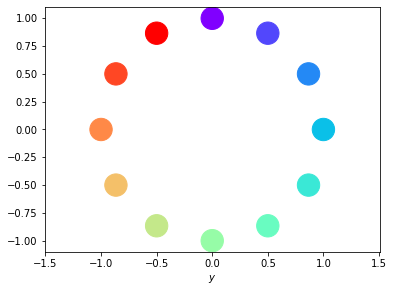

In [51]:
# setup for a unit circle
q1x = 0
q1y = 1
q2x = 0.5
q2y = np.sqrt(3)/2
q3x = np.sqrt(3)/2
q3y = 0.5
q4x = 1
q4y = 0
q5x = np.sqrt(3)/2
q5y = -0.5
q6x = 0.5
q6y = -np.sqrt(3)/2
q7x = 0
q7y = -1
q8x = -0.5
q8y = -np.sqrt(3)/2
q9x = -np.sqrt(3)/2
q9y = -0.5
q10x = -1
q10y = 0
q11x = -np.sqrt(3)/2
q11y = 0.5
q12x = -0.5
q12y = np.sqrt(3)/2

q0 = np.array([q1x,q1y,q2x,q2y,q3x,q3y,q4x,q4y,q5x,q5y,q6x,q6y,q7x,q7y,q8x,q8y,q9x,q9y,q10x,q10y,q11x,q11y,q12x,q12y])
colors = cm.rainbow(np.linspace(0, 1, 12))
# initial momentum
p0 = np.zeros(24)
plt.scatter(q0[::2],q0[1::2],s=500,color=colors) 
plt.axis('equal')
plt.xlabel('$x$')
plt.xlabel('$y$')
plt.show()

In [52]:
def Euler(q0,p0,h, force_function):
    '''
    The numerical scheme for one step of the symplectic Euler's method.
    '''
    # Compute the `force
    pe, f = force_function(q0)
    
    # Do the update

    pt = p0 + h * f
    qt = q0 + h * pt 
    
    # Compute the new energies
    pe = U(qt)
    ke = T_ke(pt)
    
    # Total energy is kinetic + potential
    total_e = ke + pe 
    
    # Return values 
    return qt, pt, total_e

In [53]:
def Verlet(q,p,h, force_function):
    '''
    The numerical scheme for one step of the Stormer-Verlet method.
    '''
    # Compute the force
    pe, f = force_function(q)
    
    # p(t+h/2)
    p_half_h = p + h/2*f
    
    # q(t+h)
    qt = q + h*p_half_h
    
    # Compute the new potential energy and force again with q(t+h)
    pe, f2 = force_function(qt)
    
    #p(t+h)
    pt = p_half_h + h/2*f2
    
    # Compute the new kinetic energy
    ke = T_ke(pt)
    
    # Total energy is kinetic + potential
    total_e = ke + pe 
    
    # Return values 
    return qt, pt, total_e

In [54]:
def TI_simp(q0,p0,h, force_function):
    '''
    The numerical scheme for one step of the simplified Takahashi-Imada method.
    '''  
    # Compute the force with q(t)
    f0 = force_function(q0)[1]
    
    # p(n+1/2)
    alpha = 1
    p1 = p0 + h/2*force_function(q0 + alpha * h**2 * f0)[1]
    
    # q(n+1)
    q = q0 + h*p1
    
    # Compute the force again with q(t+h)
    f1 = force_function(q)[1]
    
    #p(n+1)
    p2 = p1 + h/2*force_function(q + alpha * h**2 * f1)[1]

    # Compute the new energies
    ke = T_ke(p2)
    pe = U(q)

    # Total energy is kinetic + potential
    total_e = ke + pe 

    # Return values 
    return q, p2, total_e
    

In [55]:
def Yoshida(q0, p0, h, force_function):
    '''
    The numerical scheme for one step of the 4th order Yoshida method.
    ''' 

    tau0 = 1 / (2 - 2**(1/3))
    tau1 = -2**(1/3) / (2 - 2**(1/3))
    
    q1, p1, _ = Verlet(q0, p0, h*tau0, force_function)
    q2, p2, _ = Verlet(q1, p1, h*tau1, force_function)
    qt, pt, total_e = Verlet(q2, p2, h*tau0, force_function)
    
    return qt, pt, total_e

In [56]:
def run_simulation(q0, p0, Nsteps, h, step_function, force_function):
    '''
    Function for running 100 steps for a chosen method (step_function). It returns the trajectories 
    (arrays) of the position, momentum, total energies and time.
    '''
    # Initialize the output trajectories
    q_traj = [] 
    p_traj = [] 
    e_traj = [] 
    t_traj = []

    # Set initial conditions
    q = np.copy(q0)
    p = np.copy(p0)
    t = 0

    # Main loop
    for n in range(Nsteps):
        
        # Step in time
        q,p,energy = step_function(q, p, h, force_function)
        t = t + h 

        # Save the system's data
        q_traj += [q] 
        p_traj += [p] 
        e_traj += [energy] 
        t_traj += [t] 

    # Format into numpy arrays
    q_traj = np.array(q_traj)
    p_traj = np.array(p_traj) 
    
    # Return the trajectories
    return q_traj, p_traj, e_traj, t_traj

In [67]:
q0 = np.array([q1x,q1y,q2x,q2y,q3x,q3y,q4x,q4y,q5x,q5y,q6x,q6y,q7x,q7y,q8x,q8y,q9x,q9y,q10x,q10y,q11x,q11y,q12x,q12y])
p0 = np.random.randn(24) * 0.25
T = 25
h = 0.01
Nsteps = int(T/h)
q_trajE, p_trajE, e_trajE, t_trajE = run_simulation(q0, p0, Nsteps, h, Euler, total_force)
q_trajSTI, p_trajSTI, e_trajSTI, t_trajSTI = run_simulation( q0 , p0, Nsteps, h, TI_simp, total_force)
q_trajV, p_trajV, e_trajV, t_trajV = run_simulation( q0 , p0, Nsteps, h, Verlet, total_force)
q_trajY, p_trajY, e_trajY, t_trajY = run_simulation( q0 , p0, Nsteps, h, Yoshida, total_force)

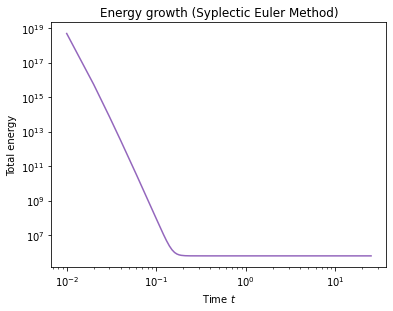

In [68]:
plt.loglog( t_trajE, e_trajE,color="tab:purple" )
plt.xlabel('Time $t$')
plt.ylabel('Total energy')
plt.title('Energy growth (Syplectic Euler Method)')
plt.show()

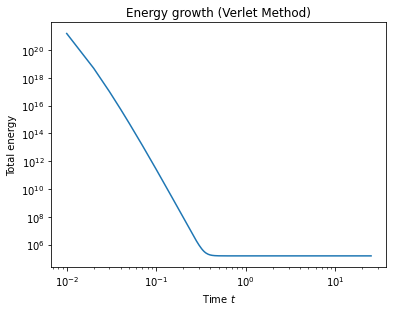

In [69]:
plt.loglog(t_trajV, e_trajV,color="tab:blue")
plt.xlabel('Time $t$')
plt.ylabel('Total energy')
plt.title('Energy growth (Verlet Method)')
plt.show()

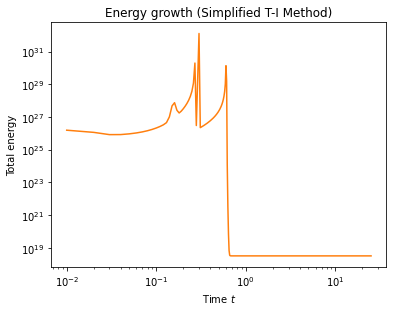

In [70]:
plt.loglog(t_trajSTI, e_trajSTI, color = "tab:orange")
plt.xlabel('Time $t$')
plt.ylabel('Total energy')
plt.title('Energy growth (Simplified T-I Method)')
plt.show()

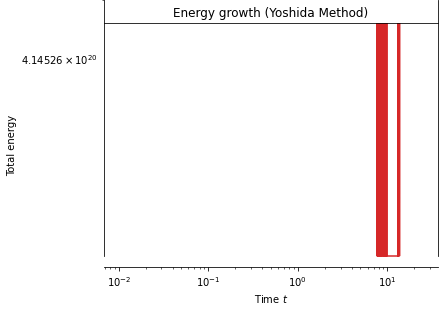

In [71]:
plt.loglog(t_trajY, e_trajY,color="tab:red")
plt.xlabel('Time $t$')
plt.ylabel('Total energy')
plt.title('Energy growth (Yoshida Method)')
plt.show()

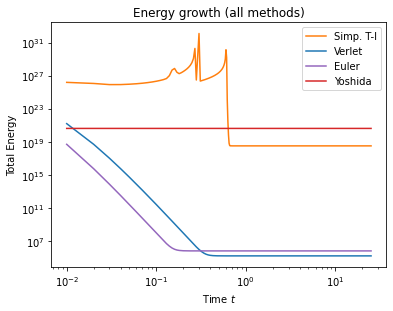

In [72]:
plt.loglog(t_trajSTI, e_trajSTI, label = 'Simp. T-I', color = "tab:orange")
plt.loglog(t_trajV, e_trajV, label = 'Verlet', color = "tab:blue")
plt.loglog(t_trajE, e_trajE, label = 'Euler',color="tab:purple")
plt.loglog(t_trajY, e_trajY, label = 'Yoshida',color="tab:red")
plt.xlabel('Time $t$')
plt.ylabel('Total Energy')
plt.title('Energy growth (all methods)')
plt.legend()
plt.savefig('12_part_tot_energy.png')
plt.show()

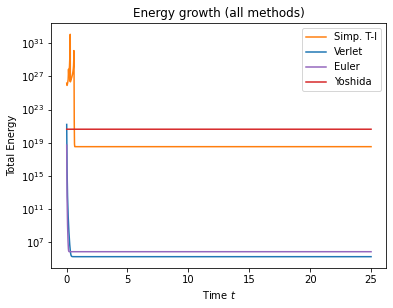

In [75]:
plt.semilogy(t_trajSTI, e_trajSTI, label = 'Simp. T-I', color = "tab:orange")
plt.semilogy(t_trajV, e_trajV, label = 'Verlet', color = "tab:blue")
plt.semilogy(t_trajE, e_trajE, label = 'Euler',color="tab:purple")
plt.semilogy(t_trajY, e_trajY, label = 'Yoshida',color="tab:red")
plt.xlabel('Time $t$')
plt.ylabel('Total Energy')
plt.title('Energy growth (all methods)')
plt.legend()
plt.savefig('12_part_tot_energy2.png')
plt.show()

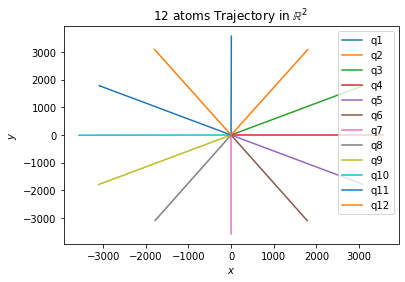

In [33]:
# trajectories with Verlet method
plt.plot( q_trajV[:,0], q_trajV[:,1] , label = 'q1') 
plt.plot( q_trajV[:,2], q_trajV[:,3], label = 'q2') 
plt.plot( q_trajV[:,4], q_trajV[:,5], label = 'q3') 
plt.plot( q_trajV[:,6], q_trajV[:,7], label = 'q4') 
plt.plot( q_trajV[:,8], q_trajV[:,9], label = 'q5') 
plt.plot( q_trajV[:,10], q_trajV[:,11], label = 'q6')
plt.plot( q_trajV[:,12], q_trajV[:,13], label = 'q7')
plt.plot( q_trajV[:,14], q_trajV[:,15], label = 'q8')
plt.plot( q_trajV[:,16], q_trajV[:,17], label = 'q9')
plt.plot( q_trajV[:,18], q_trajV[:,19], label = 'q10')
plt.plot( q_trajV[:,20], q_trajV[:,21], label = 'q11')
plt.plot( q_trajV[:,22], q_trajV[:,23], label = 'q12')

plt.xlabel('$x$')
plt.ylabel('$y$') 
plt.legend()
plt.title('12 atoms Trajectory in $\mathbb{R}^2$')
plt.show()

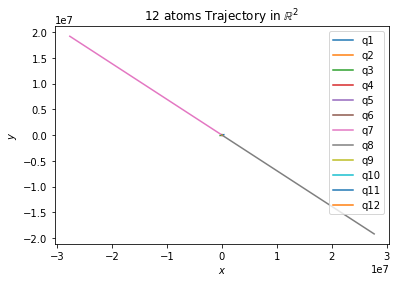

In [34]:
# trajectories with Verlet method
plt.plot( q_trajSTI[:,0], q_trajSTI[:,1] , label = 'q1') 
plt.plot( q_trajSTI[:,2], q_trajSTI[:,3], label = 'q2') 
plt.plot( q_trajSTI[:,4], q_trajSTI[:,5], label = 'q3') 
plt.plot( q_trajSTI[:,6], q_trajSTI[:,7], label = 'q4') 
plt.plot( q_trajSTI[:,8], q_trajSTI[:,9], label = 'q5') 
plt.plot( q_trajSTI[:,10], q_trajSTI[:,11], label = 'q6')
plt.plot( q_trajSTI[:,12], q_trajSTI[:,13], label = 'q7')
plt.plot( q_trajSTI[:,14], q_trajSTI[:,15], label = 'q8')
plt.plot( q_trajSTI[:,16], q_trajSTI[:,17], label = 'q9')
plt.plot( q_trajSTI[:,18], q_trajSTI[:,19], label = 'q10')
plt.plot( q_trajSTI[:,20], q_trajSTI[:,21], label = 'q11')
plt.plot( q_trajSTI[:,22], q_trajSTI[:,23], label = 'q12')

plt.xlabel('$x$')
plt.ylabel('$y$') 
plt.legend()
plt.title('12 atoms Trajectory in $\mathbb{R}^2$')
plt.show()

In [26]:
def Energy_Difference(energy_list): 
    
    # Define storage array
    Energy_Diff = []
    
    for i in range(len(energy_list)):
        # taking the absolute value of the difference bewtween every energy value and the initial
        Energy_Diff.append(abs(energy_list[0] - energy_list[i]))
        
    return max(Energy_Diff)

## non-zero p0 (random momentum), 
just for comparison, don't need to be included in the report, OR choose whether all plots will be made with random momentum

In [27]:
q0 = np.array([q1x,q1y,q2x,q2y,q3x,q3y,q4x,q4y,q5x,q5y,q6x,q6y,q7x,q7y,q8x,q8y,q9x,q9y,q10x,q10y,q11x,q11y,q12x,q12y])
p02 = np.random.randn(24) * 0.25
T = 25
h = 0.01
Nsteps = int(T/h)
q_trajE2, p_trajE2, e_trajE2, t_trajE2 = run_simulation(q0, p02, Nsteps, h, Euler, total_force)
q_trajV2, p_trajV2, e_trajV2, t_trajV2 = run_simulation(q0, p02, Nsteps, h, Verlet, total_force)
q_trajT2, p_trajT2, e_trajT2, t_trajT2 = run_simulation(q0, p02, Nsteps, h, TI_simp, total_force)
q_trajY2, p_trajY2, e_trajY2, t_trajY2 = run_simulation(q0, p02, Nsteps, h, Yoshida, total_force)

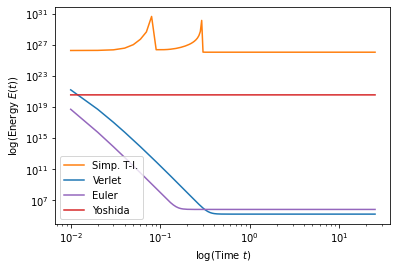

In [28]:
plt.loglog(t_trajT2, e_trajT2, label = 'Simp. T-I.', color = "tab:orange")
plt.loglog(t_trajV2, e_trajV2, label = 'Verlet',color = "tab:blue")
plt.loglog(t_trajE2, e_trajE2, label = 'Euler',color="tab:purple")
plt.loglog(t_trajY2, e_trajY2, label = 'Yoshida',color="tab:red")
plt.xlabel('Time $t$')
plt.ylabel('Total energy')
plt.title('Energy growth (all methods)')
plt.legend()
plt.show()

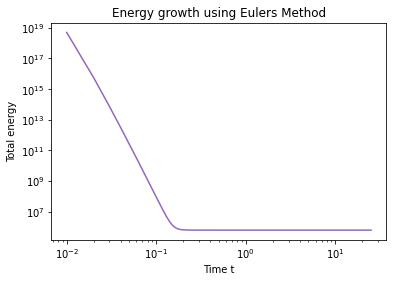

In [29]:
plt.loglog( t_trajE, e_trajE,color="tab:purple" )
plt.xlabel('Time $t$')
plt.ylabel('Total energy')
plt.title('Energy growth (Symplectic Euler Method)')
plt.show()

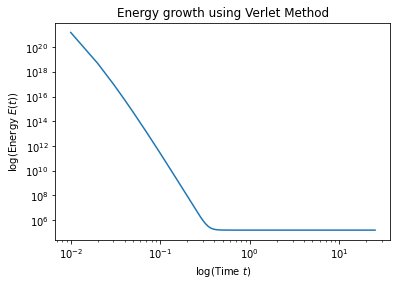

In [49]:
plt.loglog(t_trajV, e_trajV,color = "tab:blue")
plt.xlabel('Time $t$')
plt.ylabel('Total energy')
plt.title('Energy growth (Verlet Method)')
plt.show()

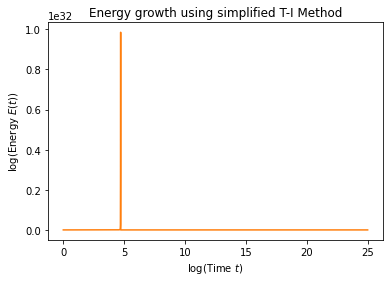

In [47]:
plt.loglog(t_trajSTI, e_trajSTI, color = "tab:orange")
plt.xlabel('Time $t$')
plt.ylabel('Total energy')
plt.title('Energy growth (Simplified T-I Method)')
plt.show()

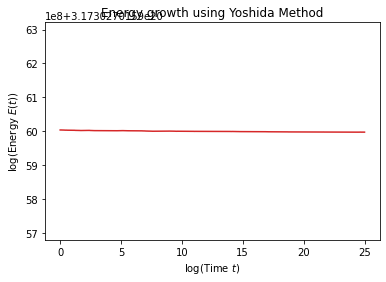

In [46]:
plt.loglog(t_trajY, e_trajY,color="tab:red") 
plt.xlabel('Time $t$')
plt.ylabel('Total energy')
plt.title('Energy growth (Yoshida Method)')
plt.show()

## Maximum energy difference

In [19]:
def Find_Traj(h,T,step_function,force_function):
    '''
    This function takes step size and time as input and using Euler's method it returns 
    corresponding trajectory arrays for q and p.
    '''

    Nsteps = int(T / h)

    # Make a copy of our initial values so we
    # don't accidently overwrite them 
    q = np.copy(q0)
    p = np.copy(p0)
    t = 0 #t0

    # Initialize our saved trajectory to be blank 
    q_traj = [] 
    p_traj = [] 
    t_traj = [] 
    e_traj = [] 

    # Run the loop 
    for n in range(Nsteps):
        t = t + h
        q,p,energy = step_function(q, p, h, force_function)

        q_traj = q_traj + [q] 
        p_traj = p_traj + [p]
        t_traj = t_traj + [t] 
        e_traj = e_traj + [energy] 

    # Make these into numpy arrays
    q_traj = np.array(q_traj)
    p_traj = np.array(p_traj)
    
    return q_traj,p_traj

def total_energy(q,p):
    pe = U(q)
    ke = T_ke(p)
    
    # Total energy is kinetic + potential
    e = ke + pe 
    return e
    
def Find_MaxDif(q_traj,p_traj,h,T):
    '''
    This function takes trajectory arrays, step size and time and returns the maximum energy difference
    of the arrays (a scalar).
    '''
    Nsteps = int(T / h)
    energydifvec = np.zeros(Nsteps)
    
    for i in range(Nsteps):
        energydifvec[i] = abs(total_energy(q0,p0)-total_energy(q_traj[i],p_traj[i]))
        
    return max(energydifvec)

In [46]:
q0 = np.array([q1x,q1y,q2x,q2y,q3x,q3y,q4x,q4y,q5x,q5y,q6x,q6y,q7x,q7y,q8x,q8y,q9x,q9y,q10x,q10y,q11x,q11y,q12x,q12y])
p0 = np.random.randn(24) * 0.25
T = 5
h = np.arange(0.001,0.1,0.001)
h_len = len(h)
maxvecSE = np.zeros(h_len)
maxvecV = np.zeros(h_len)
maxvecSTI = np.zeros(h_len)
maxvecTI = np.zeros(h_len)
maxvecY = np.zeros(h_len)

# loop over stepsizes h
for i in range(h_len):
    # saving the trajectory arrays corresponding to a particular step size into new variables
    q_trajSE,p_trajSE = Find_Traj(h[i],T,Euler,total_force)
    q_trajV,p_trajV = Find_Traj(h[i],T,Verlet,total_force)
    q_trajSTI,p_trajSTI = Find_Traj(h[i],T,TI_simp,total_force)
    q_trajY,p_trajY = Find_Traj(h[i],T,Yoshida,total_force)

    # saving the maximum value for each h in the vector of max energy differences
    maxvecSE[i] = Find_MaxDif(q_trajSE,p_trajSE,h[i],T)
    maxvecV[i] = Find_MaxDif(q_trajV,p_trajV,h[i],T)
    maxvecSTI[i] = Find_MaxDif(q_trajSTI,p_trajSTI,h[i],T)
    maxvecY[i] = Find_MaxDif(q_trajY,p_trajY,h[i],T)

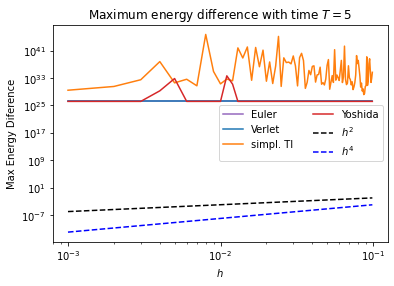

In [47]:
# the same as before, but shown that they are of O(h^2) (in the loglog scale)
plt.loglog(h,maxvecSE,label='Euler',color = 'tab:purple')
plt.loglog(h,maxvecV,label="Verlet",color = "tab:blue")
plt.loglog(h,maxvecSTI,label="simpl. TI",color="tab:orange")
#plt.loglog(h,maxvecTI,label="TI",color="tab:green")
plt.loglog(h,maxvecY,label="Yoshida",color="tab:red")
plt.loglog(h,h**2,'--k',label="$h^2$")
plt.loglog(h,h**4,'--b',label="$h^4$")

plt.xlabel('$h$')
plt.ylabel('Max Energy Diference') 
plt.title('Maximum energy difference with time $T=5$')
plt.legend(ncol = 2)
plt.savefig('12_part_all_K_bigger.png')
plt.show()